# Sentiment Analysis with Xgboost

Predict the `score` assigned with each text amazon fine food reviews using xgboost.

### Libraries

In [137]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # colorful plots
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score #evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time #check runtime

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dena1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [138]:
#--------------------------------------------------------------------------------
# Constants and Configurations

DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
NROWS = 50 #edit with a smaller size to develop faster
TOKENIZER = nltk.word_tokenize 
STEMMER = nltk.PorterStemmer()


# TODO: Seperate this into a seperate file/ library so we can load it into all the scripts
def load_data(file):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    return pd.read_csv(path + file, nrows=NROWS)


# Load Reviews.csv
reviewsdf = load_data("Reviews.csv")

#drop columns not needed
reviewsdf.drop(columns=["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"], inplace=True, axis=1)
reviewsdf.head()

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...


### Data Preprocessing

Going to tokenize the words and anything that might need to be removed (stopwords, puncutation, etc) :

In [139]:
# parse the text into tokens and apply to the table
def tokenize(row):
    row["Text"] = TOKENIZER(row["Text"]) #tokenize
    row["Tokenized_Text"] = [] + row["Text"]
    return row
    
# stemming shortens the sentences by combining words with the same meaning 
# nltk assumes that the ewviews are in english
def apply_stem(row):
    row["Tokenized_Text"] = list(map(lambda str: STEMMER.stem(str), row["Tokenized_Text"]))
    return row
    
#apply
reviewsdf = reviewsdf.apply(tokenize, axis=1)
reviewsdf.head()
reviewsdf = reviewsdf.apply(apply_stem, axis=1)
reviewsdf.head()


,Id,Score,Text,Tokenized_Text
0,1,5,"[I, have, bought, several, of, the, Vitality, ...","[I, have, bought, sever, of, the, vital, can, ..."
1,2,1,"[Product, arrived, labeled, as, Jumbo, Salted,...","[product, arriv, label, as, jumbo, salt, peanu..."
2,3,4,"[This, is, a, confection, that, has, been, aro...","[thi, is, a, confect, that, ha, been, around, ..."
3,4,2,"[If, you, are, looking, for, the, secret, ingr...","[If, you, are, look, for, the, secret, ingredi..."
4,5,5,"[Great, taffy, at, a, great, price, ., There, ...","[great, taffi, at, a, great, price, ., there, ..."


### Distribution

Look at the distribution of different scores and words received for each text review.

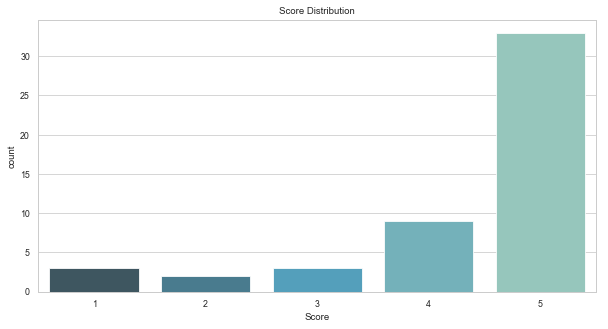

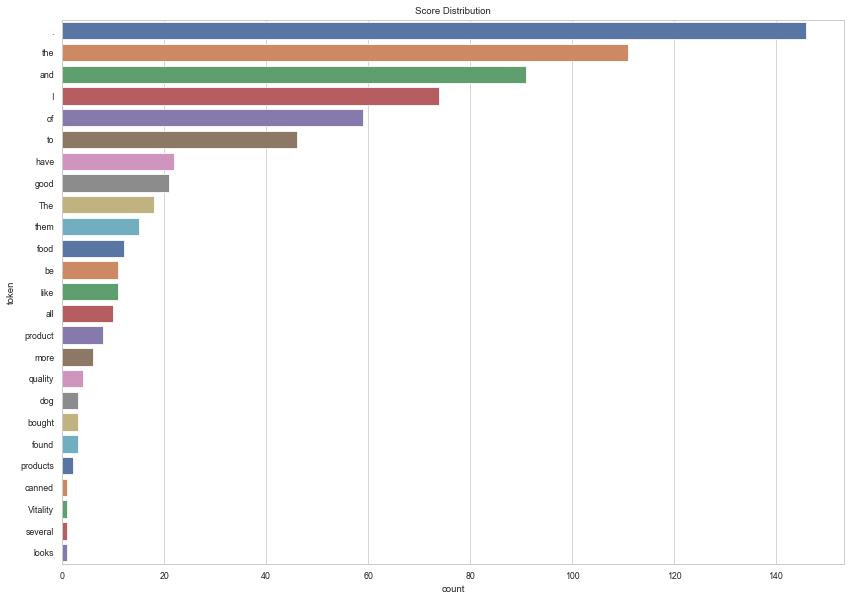

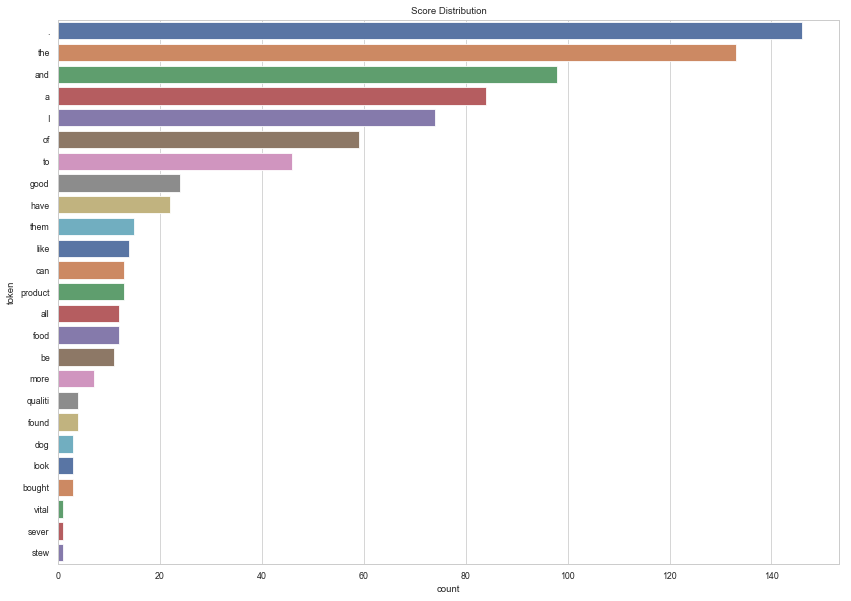

In [140]:
plt.subplots(figsize=(10,5))
sns.set(style="whitegrid", context="paper") #loooks nicer with a blank background
sns.countplot(x="Score", data=reviewsdf, palette="GnBu_d").set_title("Score Distribution")
plt.show()

def plot_word_count(columname):
    words = Counter() #count words
    for idx in reviewsdf.index:
        words.update(reviewsdf.loc[idx, columname])
    plt.subplots(figsize=(14,10))
    wordsdf = pd.DataFrame.from_dict(words, orient='index').reset_index()
    wordsdf = wordsdf.head(25)
    wordsdf = wordsdf.rename(columns={'index': 'token', 0:'count'})
    wordsdf = wordsdf.sort_values('count', ascending=False)
    sns.barplot(x=wordsdf['count'], y=wordsdf['token'], palette="deep").set_title("Score Distribution")
    plt.show()

plot_word_count('Text')
plot_word_count('Tokenized_Text')

In [142]:
#Remove stopwords and unecessar content and repeat
